# Street Network comparison between midtown and lower manhattan (Walkable distance vs euclidean)
hypothesis: the quality of how good street network is could be measured by **total walkable area / total circular area** within same distance.

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Point, Polygon
import pandas as pd
import requests
import networkx as nx
import osmnx as ox
import h3
import libpysal as lps

In [2]:
# we'll begin by borrowing the plotting helper function we created in the geoprocessing notebook for use here.
# oftentimes when writing functions that we want to come back to, we can create a new python file (such as utils.py)
# and import functions from there.
def set_axis_off():
    """
    Set the default matplotlib settings to turn off axes and ticks.
    This function modifies the global matplotlib configuration to hide axes and ticks
    for all plots created after this function is called.
    """
    # set axis off by default
    plt.rcParams["axes.axisbelow"] = False
    plt.rcParams["axes.axisbelow"] = False
    plt.rcParams["axes.spines.left"] = False
    plt.rcParams["axes.spines.right"] = False
    plt.rcParams["axes.spines.top"] = False
    plt.rcParams["axes.spines.bottom"] = False

    # set tick params off by default
    plt.rcParams["xtick.bottom"] = False
    plt.rcParams["xtick.top"] = False
    plt.rcParams["xtick.labelbottom"] = False
    plt.rcParams["xtick.labeltop"] = False
    plt.rcParams["ytick.left"] = False
    plt.rcParams["ytick.right"] = False
    plt.rcParams["ytick.labelleft"] = False
    plt.rcParams["ytick.labelright"] = False

set_axis_off()

# Street Network in Midtown (Time Square Area)

In [16]:
bbox_midtown = (-73.99, 40.75, -73.975, 40.764)
bbox_lowermh = (-74.015, 40.703, -74.00, 40.715)

In [17]:
mh_network_midtown = ox.graph_from_point(
    (40.758027, -73.985518),
    dist=1000,
    network_type="walk",
)
mh_network_lowermh = ox.graph_from_point(
    (40.709165, -74.010546),
    dist=1000,
    network_type="walk",
)


midtown_net_nodes, midtown_net_edges = ox.graph_to_gdfs(mh_network_midtown)
lowermh_net_nodes, lowermh_net_edges = ox.graph_to_gdfs(mh_network_lowermh)

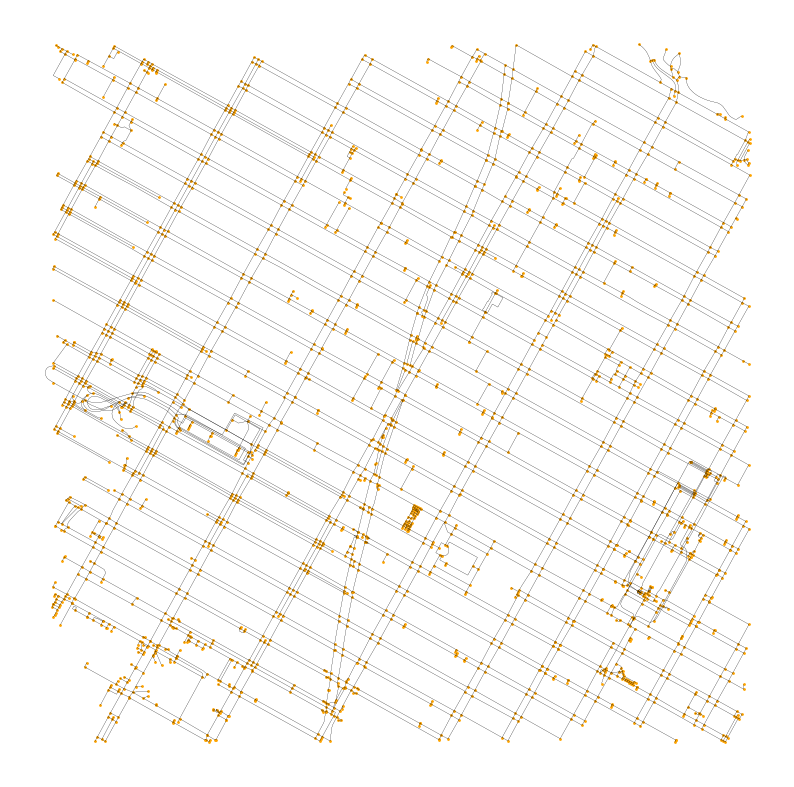

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))
midtown_net_edges.plot(ax=ax, color="black", linewidth=0.1)
midtown_net_nodes.plot(ax=ax, color="orange", markersize=1).set_axis_off()

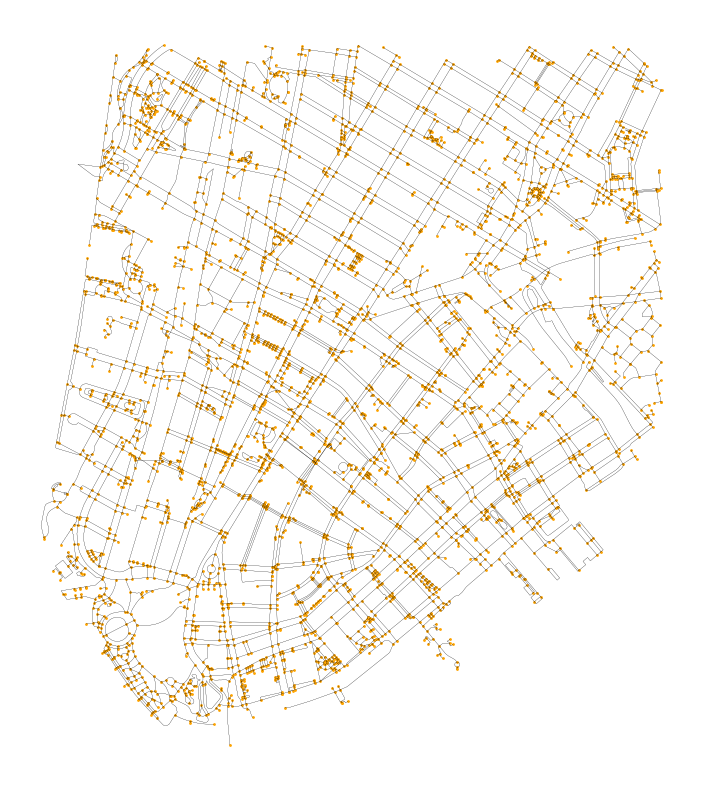

In [53]:
fig, ax = plt.subplots(figsize=(10, 10))
lowermh_net_edges.plot(ax=ax, color="black", linewidth=0.1)
lowermh_net_nodes.plot(ax=ax, color="orange", markersize=1).set_axis_off()

In [20]:
midtown_center = Point(-73.985518, 40.758027)
lowermh_center = Point(-74.010546, 40.709165)

C:\Users\kdgki\AppData\Local\Temp\ipykernel_36444\283105310.py:24: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  convex_poly_midtown = reach_nodes_midtown.unary_union.convex_hull
C:\Users\kdgki\AppData\Local\Temp\ipykernel_36444\283105310.py:39: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


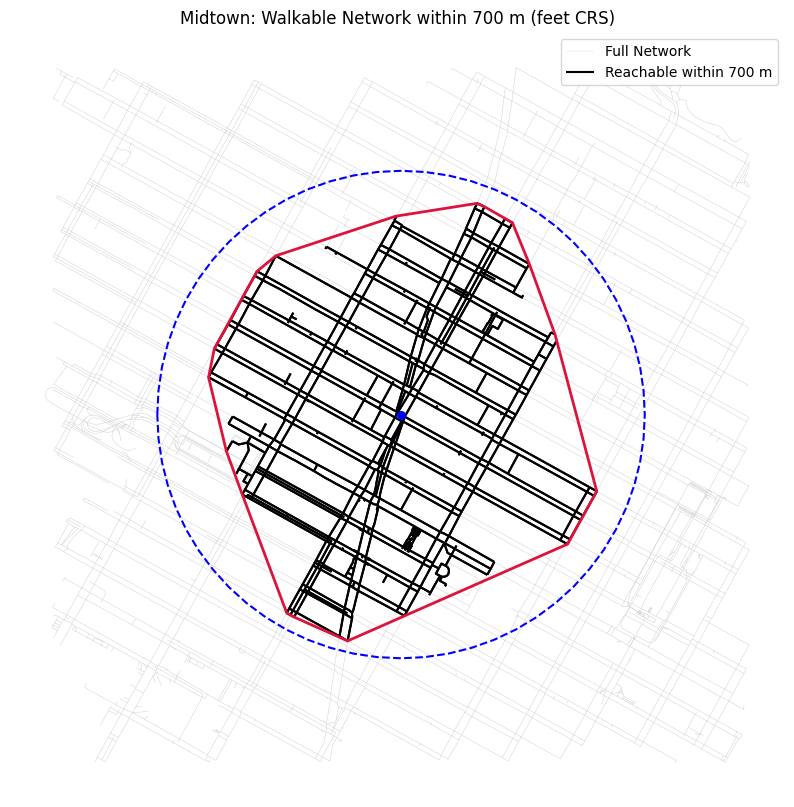

In [66]:
center_node = ox.distance.nearest_nodes(mh_network_midtown, midtown_center.x, midtown_center.y)
walk_limit_m = 700

# Step 3: Compute network distances from the center node
lengths = nx.single_source_dijkstra_path_length(mh_network_midtown, center_node, cutoff=walk_limit_m, weight='length')

reachable_nodes = set(lengths.keys())
subgraph = mh_network_midtown.subgraph(reachable_nodes).copy()

# Step 5: Convert to GeoDataFrames
nodes_gdf, edges_gdf = ox.graph_to_gdfs(subgraph)

# Step 6: Plot
G_midtown_proj  = ox.project_graph(mh_network_midtown,  to_crs="EPSG:2263")
midtown_nodes, midtown_edges = ox.graph_to_gdfs(G_midtown_proj)
midtown_center_2263 = gpd.GeoSeries([midtown_center], crs="EPSG:4326").to_crs(midtown_edges.crs)

midtown_circle = midtown_center_2263.buffer(walk_limit_m*3.28)
edges_gdf_2263 = edges_gdf.to_crs(midtown_edges.crs)

reachable_ids = list(lengths.keys())  # dict from Dijkstra
reach_nodes_midtown = midtown_nodes.loc[reachable_ids].copy()

convex_poly_midtown = reach_nodes_midtown.unary_union.convex_hull

# 6) Plot (always pass the same ax; set equal aspect; use zorder)
fig, ax = plt.subplots(figsize=(10, 10))
midtown_edges.plot(ax=ax, color="lightgrey", linewidth=0.2, label="Full Network", zorder=1)
edges_gdf_2263.plot(ax=ax, color="black", linewidth=1.5, label="Reachable within 700 m", zorder=2)
midtown_circle.plot(ax=ax, facecolor="none", edgecolor="blue", linestyle="--",
                    linewidth=1.5, label="700 m radius", zorder=3)
midtown_center_2263.plot(ax=ax, color="blue", markersize=30, zorder=4)
gpd.GeoSeries([convex_poly_midtown], crs=midtown_edges.crs).plot(
    ax=ax, facecolor="none", edgecolor="crimson", linewidth=2, zorder=4, label="Max-area boundary"
)

ax.set_aspect("equal")
ax.set_title("Midtown: Walkable Network within 700 m (feet CRS)")
ax.legend()
plt.show()

C:\Users\kdgki\AppData\Local\Temp\ipykernel_36444\326592323.py:24: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  convex_poly_lowermh = reach_nodes_lowermh.unary_union.convex_hull
C:\Users\kdgki\AppData\Local\Temp\ipykernel_36444\326592323.py:39: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


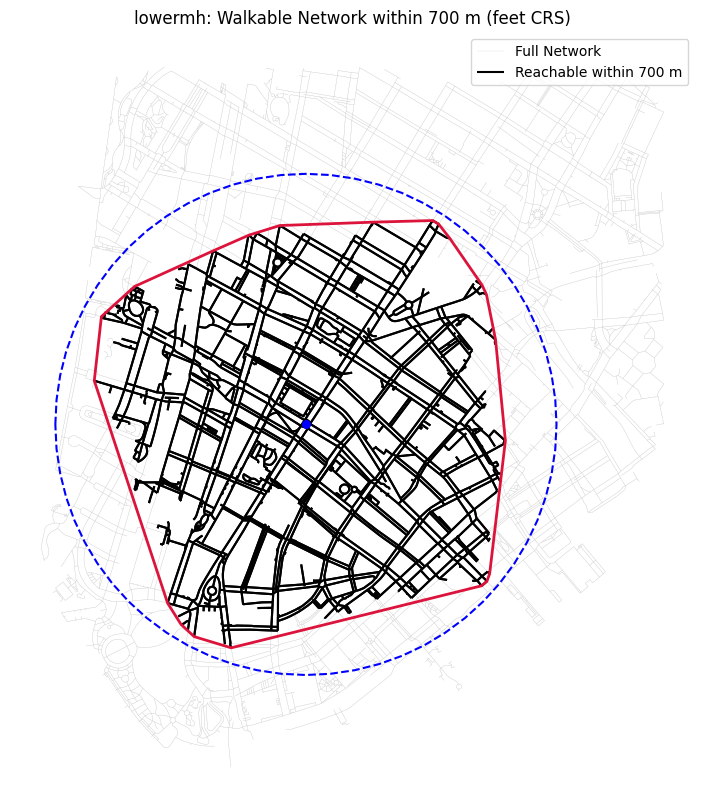

In [67]:
center_node = ox.distance.nearest_nodes(mh_network_lowermh, lowermh_center.x, lowermh_center.y)
walk_limit_m = 700

# Step 3: Compute network distances from the center node
lengths = nx.single_source_dijkstra_path_length(mh_network_lowermh, center_node, cutoff=walk_limit_m, weight='length')

reachable_nodes = set(lengths.keys())
subgraph = mh_network_lowermh.subgraph(reachable_nodes).copy()

# Step 5: Convert to GeoDataFrames
nodes_gdf, edges_gdf = ox.graph_to_gdfs(subgraph)

# Step 6: Plot
G_lowermh_proj  = ox.project_graph(mh_network_lowermh,  to_crs="EPSG:2263")
lowermh_nodes, lowermh_edges = ox.graph_to_gdfs(G_lowermh_proj)
lowermh_center_2263 = gpd.GeoSeries([lowermh_center], crs="EPSG:4326").to_crs(lowermh_edges.crs)

lowermh_circle = lowermh_center_2263.buffer(walk_limit_m*3.28)
edges_gdf_2263 = edges_gdf.to_crs(lowermh_edges.crs)

reachable_ids = list(lengths.keys())  # dict from Dijkstra
reach_nodes_lowermh = lowermh_nodes.loc[reachable_ids].copy()

convex_poly_lowermh = reach_nodes_lowermh.unary_union.convex_hull

# 6) Plot (always pass the same ax; set equal aspect; use zorder)
fig, ax = plt.subplots(figsize=(10, 10))
lowermh_edges.plot(ax=ax, color="lightgrey", linewidth=0.2, label="Full Network", zorder=1)
edges_gdf_2263.plot(ax=ax, color="black", linewidth=1.5, label="Reachable within 700 m", zorder=2)
lowermh_circle.plot(ax=ax, facecolor="none", edgecolor="blue", linestyle="--",
                    linewidth=1.5, label="700 m radius", zorder=3)
lowermh_center_2263.plot(ax=ax, color="blue", markersize=30, zorder=4)
gpd.GeoSeries([convex_poly], crs=lowermh_edges.crs).plot(
    ax=ax, facecolor="none", edgecolor="crimson", linewidth=2, zorder=4, label="Max-area boundary"
)

ax.set_aspect("equal")
ax.set_title("lowermh: Walkable Network within 700 m (feet CRS)")
ax.legend()
plt.show()

In [73]:
import math

midtown_700walkable_area = convex_poly_midtown.area
lowermh_700walkable_area = convex_poly_lowermh.area

midtown_700circle_area = math.pi * ((700*3.28084) ** 2)
lowermh_700circle_area = math.pi * ((700*3.28084) ** 2)

midtown_network_quality = midtown_700walkable_area / midtown_700circle_area
lowermh_network_quality = lowermh_700walkable_area / lowermh_700circle_area

print(midtown_network_quality)
print(lowermh_network_quality)

0.6477051703424954
0.7076418662795252


# Findings:

Just by comparing the value, the lower manhattan had a higher value (70.8% of area of the same distance circle is reacable)

However, this analysis is very limited due to several factors:
1. the maximum walkable distance is only measued to the maximum reachable nodes because edges are not subdivided smaller. disadvantageous for midtown, which has longer edges in general
2. In order to measure which type of street network is better (grid vs irregular), this analysis is very limited. Because lower manhattan might have higher value simply because there are denser compared to midtown

So I think the analysis itself is a failure, but it was a meaningful time trying to visualize the walkable vs full radius :)